In [142]:
%%capture stored_output
%load_ext autoreload
%autoreload 2

In [143]:
import seaborn as sns
import pandas as pd

import warnings

warnings.filterwarnings("ignore")

## Comparing results

In [144]:
PARQUETS = ["../results/cloud_results_gaussian_adversarial.parquet"]
STEPS_PER_EPOCH = 2000
ALGOS = [
    "0.1 BCQ",
    "0.1 AugmentedBCQ",
    "1.0 BCQ",
    "0.1 DiscreteBCQ",
    "0.1 AugmentedDiscreteBCQ",
    "1.0 DiscreteBCQ",
]
EXCLUDED_ENVS = ["cartpole-replay"]

In [145]:
def is_outlier(s):
    q1 = s.quantile(0.05)
    q3 = s.quantile(0.95)
    irq = q3 - q1
    lower_limit = q1 - 1.5 * irq
    upper_limit = q3 + 1.5 * irq
    return ~s.between(lower_limit, upper_limit)

In [146]:
results = []
for f in PARQUETS:
    r = pd.read_parquet(f)
    r["steps"] = r["epoch"] * STEPS_PER_EPOCH
    results.append(r)
results_df_full = pd.concat(results)
results_df_full["algo"] = results_df_full["algo"].str.replace("Discrete", "")

In [147]:
results_df_filter_env = results_df_full[~results_df_full["env"].isin(EXCLUDED_ENVS)]
results_df_filter_algo = results_df_full[results_df_full["algo"].isin(ALGOS)]
results_df = results_df_filter_algo.merge(
    results_df_filter_env, on=["env", "algo"], suffixes=("", "_delme")
)
results_df = results_df[[c for c in results_df.columns if not c.endswith("_delme")]]
results_df = results_df.drop_duplicates(subset=results_df.columns).reset_index()
results_df = results_df.iloc[::1].reset_index()

In [148]:
# keep colors across plots
palette_dict = {
    continent: color
    for continent, color in zip(results_df["algo"].unique(), sns.color_palette("tab10"))
}

### Reward - value

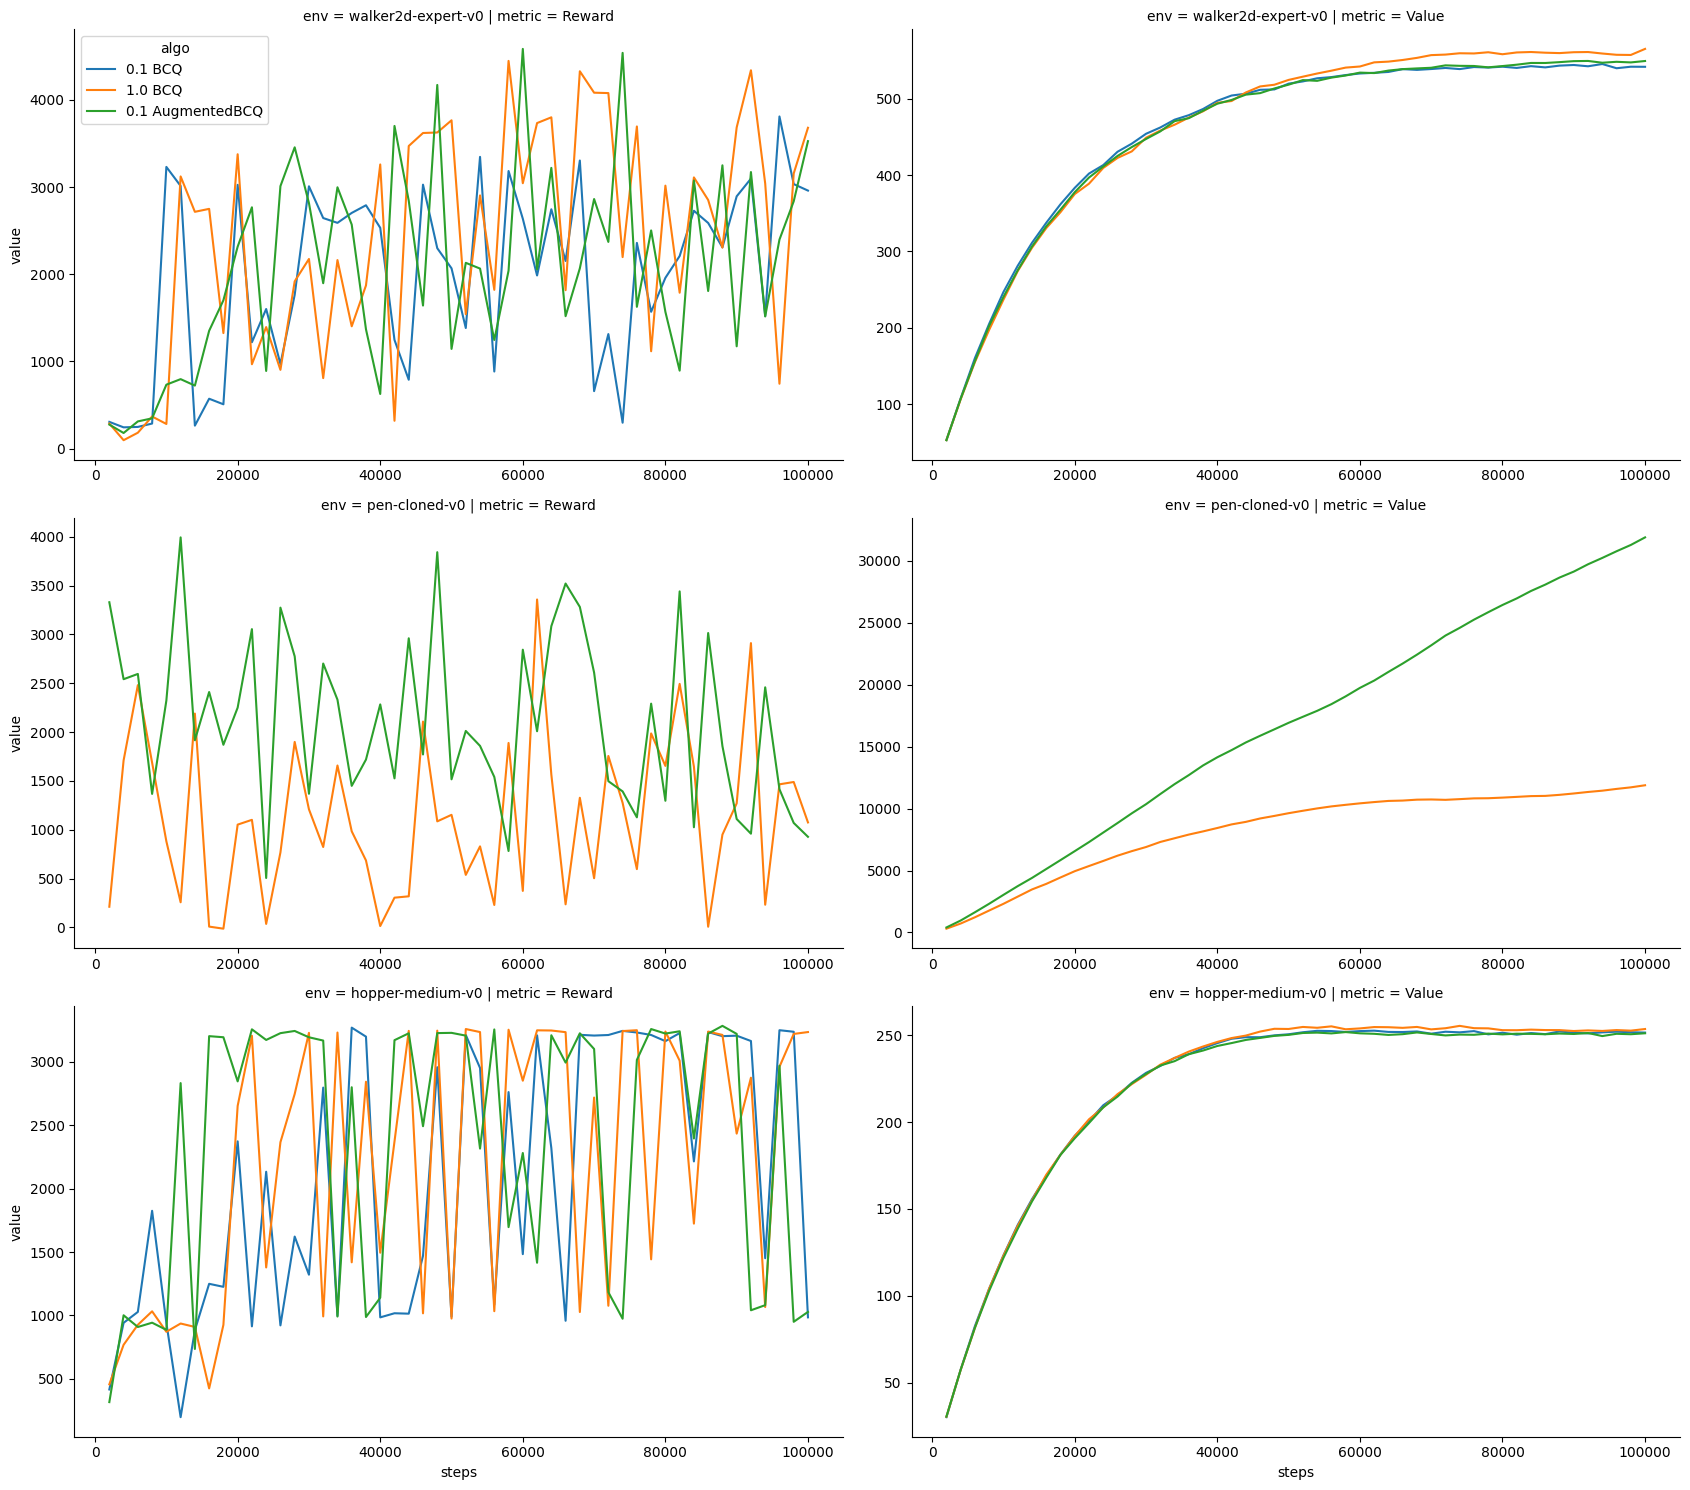

In [149]:
results_value = results_df[
    ["env", "algo", "average_value_estimation_scorer", "steps"]
].dropna()
results_reward = results_df[["env", "algo", "environment_reward", "steps"]].dropna()
results_reward = results_reward.rename({"environment_reward": "value"}, axis=1)
results_value = results_value.rename(
    {"average_value_estimation_scorer": "value"}, axis=1
)
results_reward["metric"] = "Reward"
results_value["metric"] = "Value"
res = pd.concat([results_reward, results_value])
g = sns.FacetGrid(
    res,
    col="metric",
    hue="algo",
    row="env",
    height=5,
    aspect=1.7,
    legend_out=False,
    sharey=False,
    sharex=False,
    palette=palette_dict,
)
g.map_dataframe(sns.lineplot, "steps", "value")
g.add_legend()

### TD - advantage

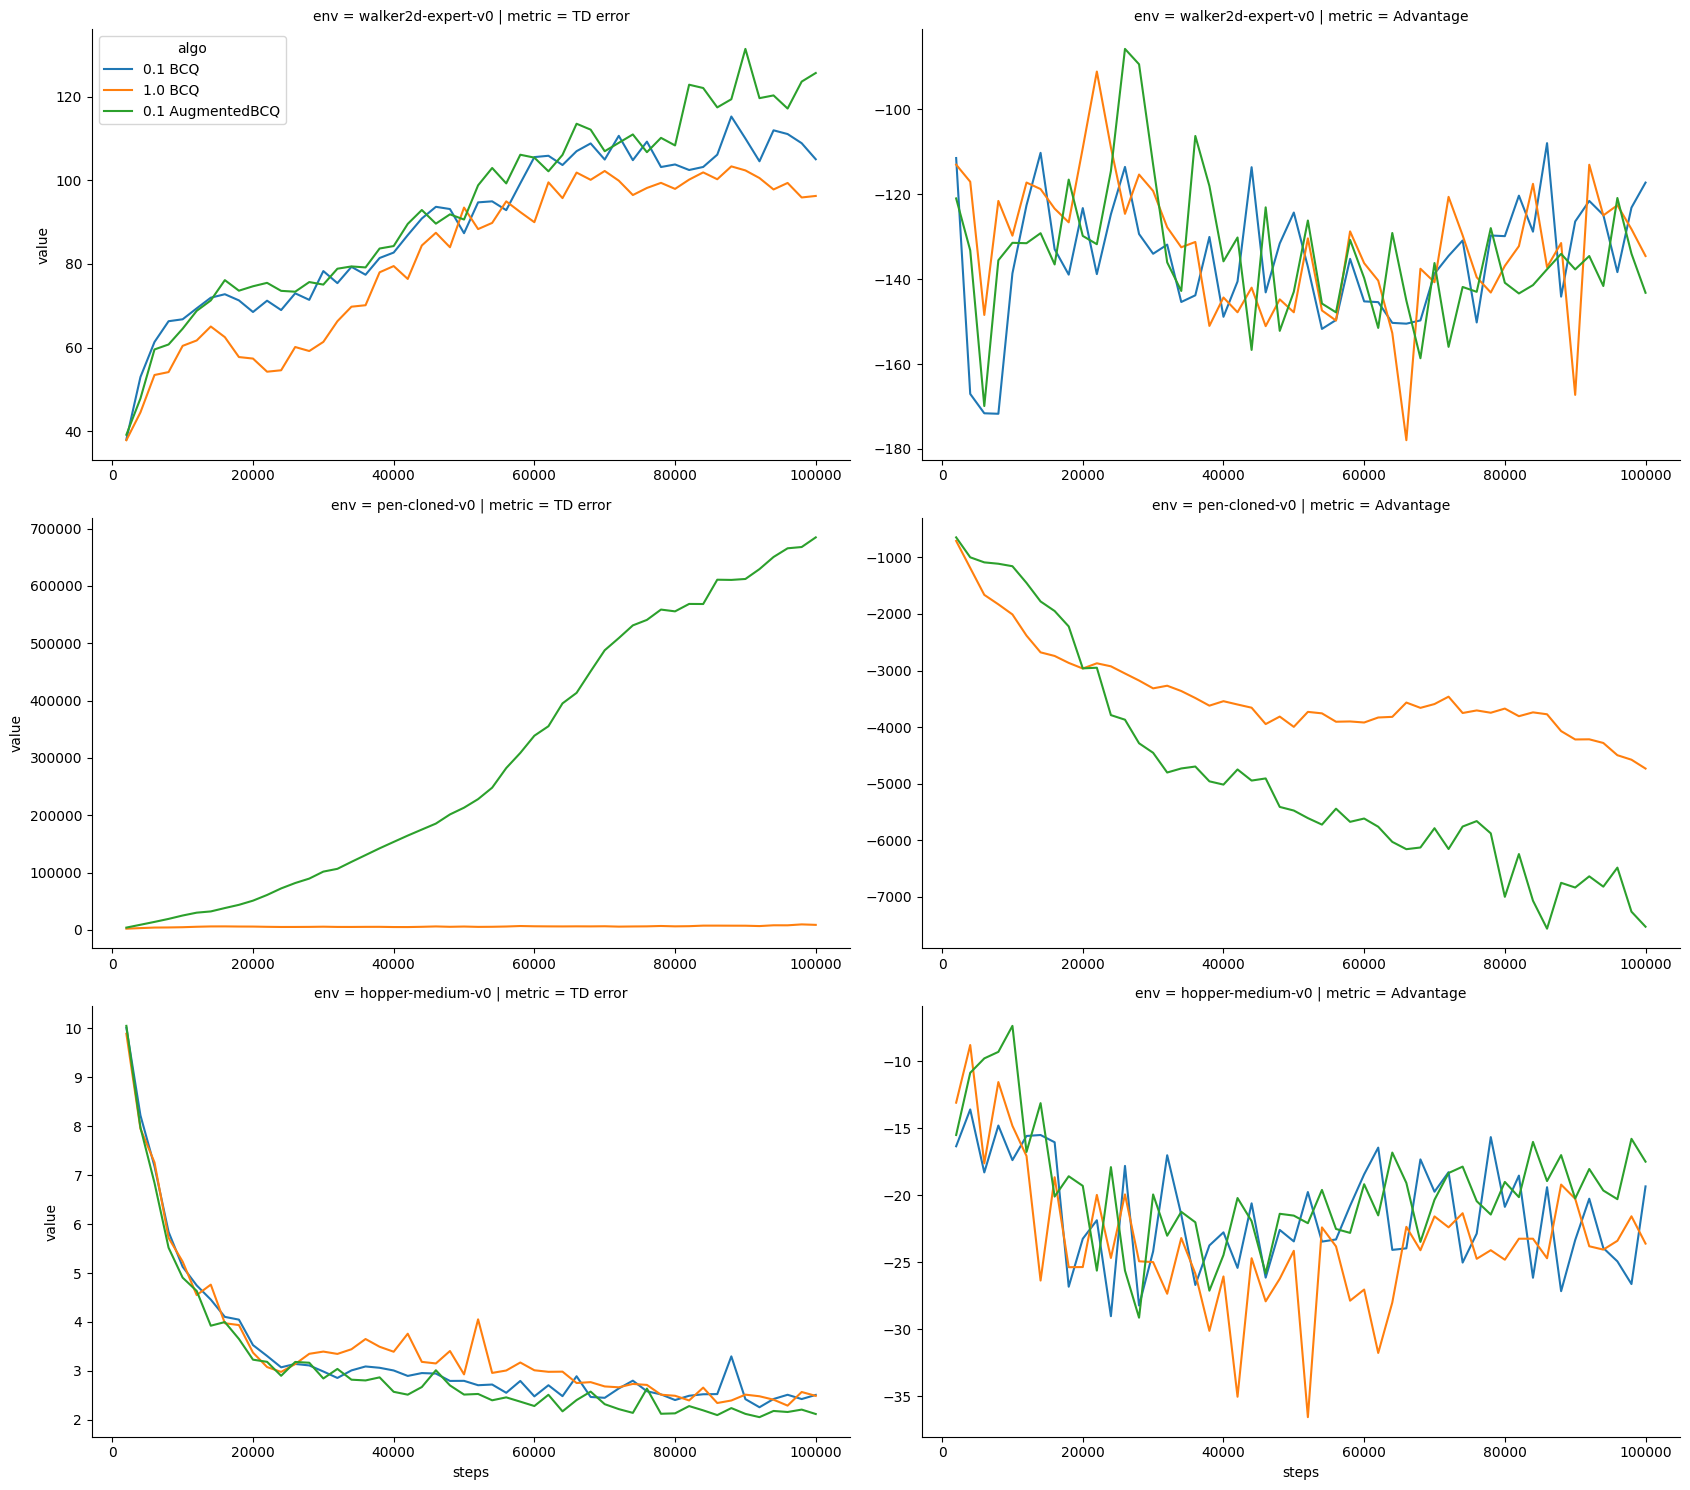

In [150]:
results_advantage = results_df[
    ["env", "algo", "discounted_sum_of_advantage_scorer", "steps"]
].dropna()
results_td = results_df[["env", "algo", "td_error_scorer", "steps"]].dropna()
results_td = results_td.rename({"td_error_scorer": "value"}, axis=1)
results_advantage = results_advantage.rename(
    {"discounted_sum_of_advantage_scorer": "value"}, axis=1
)
results_td["metric"] = "TD error"
results_advantage["metric"] = "Advantage"
res_2 = pd.concat([results_td, results_advantage])
g = sns.FacetGrid(
    res_2,
    col="metric",
    hue="algo",
    row="env",
    height=5,
    aspect=1.7,
    legend_out=False,
    sharey=False,
    sharex=False,
    palette=palette_dict,
)
g.map_dataframe(sns.lineplot, "steps", "value")
g.add_legend()

## Max reward

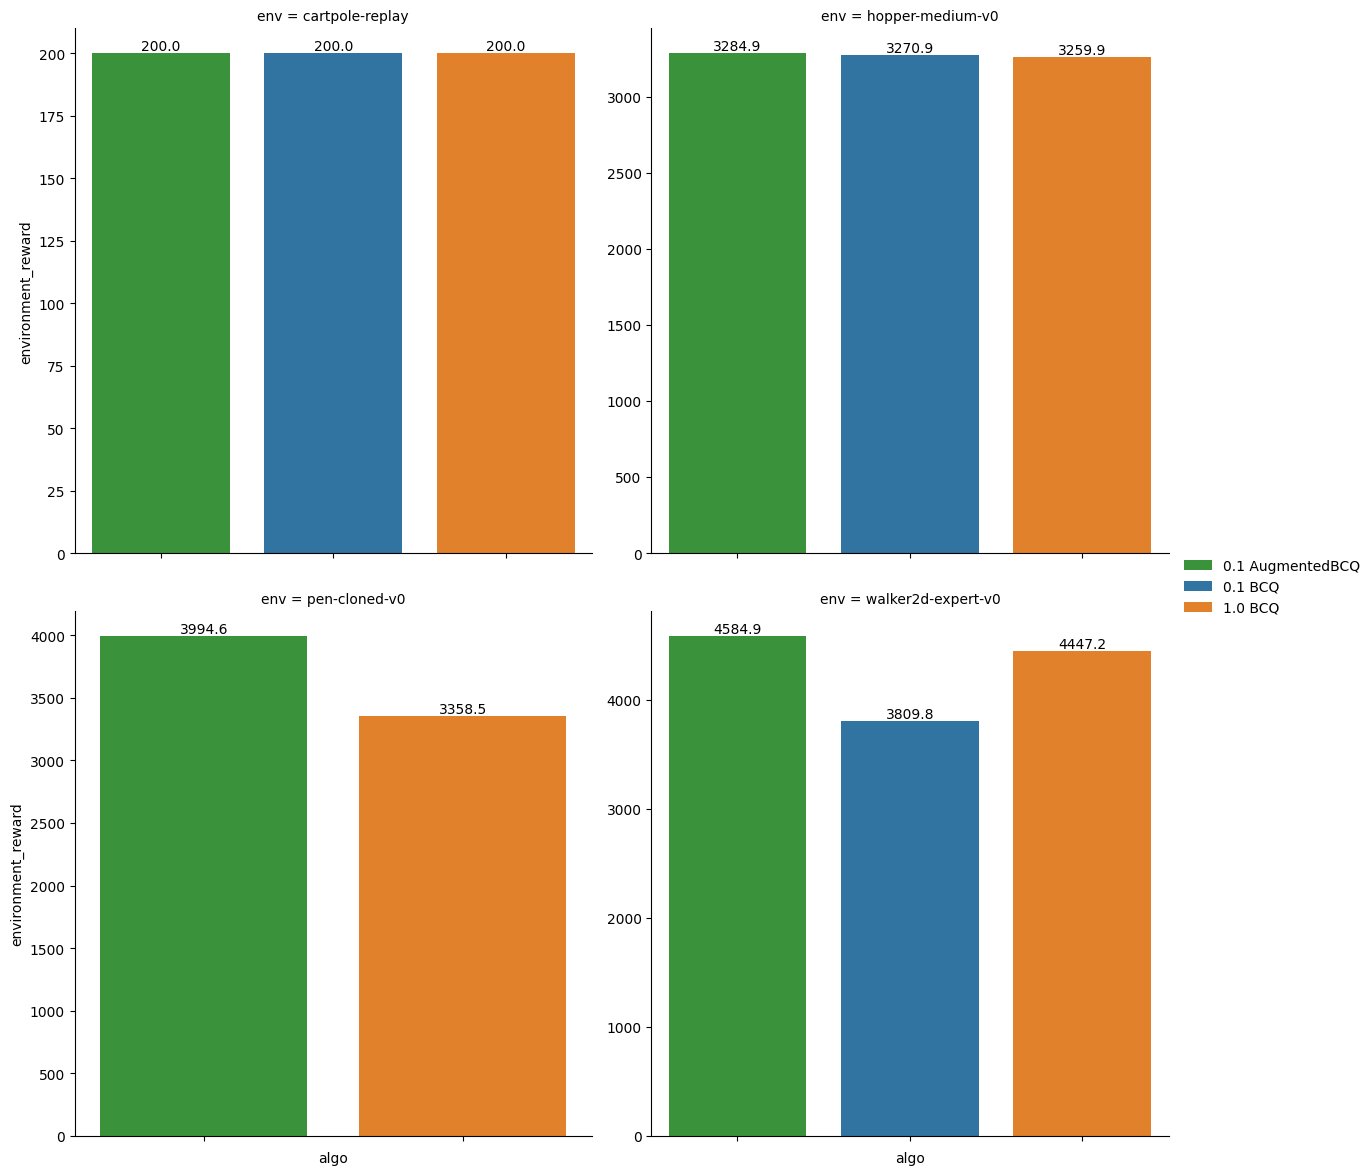

In [151]:
res_max = results_df_filter_algo[["env", "algo", "environment_reward"]].dropna()
res_max = res_max.groupby(["env", "algo"]).max().reset_index()
g = sns.catplot(
    data=res_max,
    x="algo",
    hue="algo",
    y="environment_reward",
    col="env",
    col_wrap=2,
    kind="bar",
    height=6,
    dodge=False,
    palette=palette_dict,
    legend=True,
    sharey=False,
    sharex=False,
)
g.add_legend()
g.set(xticklabels=[])
axs = [g.facet_axis(0, i) for i in range(res_max["env"].nunique())]
for ax in axs:
    for c in ax.containers:
        labels = [f"{(v.get_height()):.1f}" for v in c]
        ax.bar_label(c, labels=labels, label_type="edge")